# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](https://compsci682-fa18.github.io/assignments2018/assignment1/) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs682.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs682/datasets/cifar-10-batches-py'
    
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs682/classifiers/softmax.py**. 


In [38]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs682/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs682.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print(loss)
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

2.33978817099695
loss: 2.339788
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *Fill this in*
The loss is calculated by -log(e^correct class score/sum e^everyclass) Because W is random, the scores for each class should be almost the same, so we take 1/10 which is 0.1 inside and calculate the loss to be -log(0.1).

In [39]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs682.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 1.703083 analytic: 1.703083, relative error: 2.873026e-08
numerical: 3.734820 analytic: 3.734820, relative error: 1.500087e-08
numerical: -3.482265 analytic: -3.482265, relative error: 1.960710e-08
numerical: 0.231430 analytic: 0.231430, relative error: 1.850060e-07
numerical: -2.126774 analytic: -2.126774, relative error: 8.972951e-09
numerical: -3.672432 analytic: -3.672433, relative error: 1.573700e-08
numerical: 3.846122 analytic: 3.846122, relative error: 1.959140e-08
numerical: -1.471067 analytic: -1.471067, relative error: 2.455031e-08
numerical: 1.807050 analytic: 1.807049, relative error: 3.805597e-08
numerical: 1.314619 analytic: 1.314619, relative error: 2.814139e-08
numerical: 0.492187 analytic: 0.492187, relative error: 2.118962e-08
numerical: 0.992400 analytic: 0.992400, relative error: 3.830842e-08
numerical: 4.373839 analytic: 4.373839, relative error: 3.104853e-09
numerical: -5.368140 analytic: -5.368140, relative error: 3.694423e-09
numerical: -0.519622 ana

In [52]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs682.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.339788e+00 computed in 0.146919s
vectorized loss: 2.487902e+00 computed in 0.012992s
Loss difference: 0.148114
Gradient difference: 0.000000


In [54]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs682.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None

learning_rates = [1e-7, 5e-7]
regularization_strengths = [2.5e4, 5e4]
num_folds = 5

X_train_folds = np.array_split(X_train, num_folds)
y_train_folds = np.array_split(y_train, num_folds)
small_num_iters = 300 # the original is 1500


#for each comb of the params
for i in range (0, len(learning_rates)):
    for n in range (0, len(regularization_strengths)):
        #for each part we are going to use as test
        templr = learning_rates[i]
        temprs = regularization_strengths[n]
        results[(templr, temprs)]=[]
        #for each fold of the cross validation
        for j in range (0, num_folds):
            #train the model using the four parts
            #get the four parts
            temparray4_x = []
            temparray4_y = []
            for k in range (0, num_folds):
                if(k!=j):
                    temparray4_x.append(X_train_folds[k])
                    temparray4_y.append(y_train_folds[k])
            temptrain_X = np.concatenate(temparray4_x)
            temptrain_y = np.concatenate(temparray4_y)
        
            #get the test data
            temptest_X = X_train_folds[j]
            temptest_y = y_train_folds[j]
            
            #svm
            tempclassifier = Softmax()
            tempclassifier.train(temptrain_X, temptrain_y, learning_rate=templr, reg=temprs,
                      num_iters=small_num_iters, verbose=True)
        
            #vali pred
            temppred_y = tempclassifier.predict(temptest_X)
            #training pred
            temppred_y_tr = tempclassifier.predict(temptrain_X)
            # Compute and print the fraction of correctly predicted examples
            #tempnum_correct = np.sum(temppred_y == temptest_y)
            #tempnum_correct_tr = np.sum(temppred_y_tr == temptrain_y)

            #training acc
            #accuracy_t = float(tempnum_correct_tr) / temptrain_X.shape[0]
            #validation acc
            #accuracy_v = float(tempnum_correct) / temptest_X.shape[0]
            accuracy_t = np.mean(temppred_y_tr == temptrain_y)
            accuracy_v = np.mean(temppred_y == temptest_y)


        
            #append to the tempacu
            results[(templr, temprs)] = (accuracy_t,accuracy_v)
            
            if accuracy_v > best_val:
                best_val = accuracy_v
                best_softmax = tempclassifier


################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
# Your code
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 300: loss 394.509281
iteration 100 / 300: loss 236.004840
iteration 200 / 300: loss 144.350604
(9800, 3073)
(39200, 3073)
iteration 0 / 300: loss 393.197503
iteration 100 / 300: loss 237.335759
iteration 200 / 300: loss 144.171360
(9800, 3073)
(39200, 3073)
iteration 0 / 300: loss 386.101938
iteration 100 / 300: loss 233.537292
iteration 200 / 300: loss 143.057019
(9800, 3073)
(39200, 3073)
iteration 0 / 300: loss 390.077261
iteration 100 / 300: loss 236.034635
iteration 200 / 300: loss 144.417262
(9800, 3073)
(39200, 3073)
iteration 0 / 300: loss 387.486547
iteration 100 / 300: loss 235.044860
iteration 200 / 300: loss 143.202615
(9800, 3073)
(39200, 3073)
iteration 0 / 300: loss 768.943294
iteration 100 / 300: loss 283.351592
iteration 200 / 300: loss 105.016619
(9800, 3073)
(39200, 3073)
iteration 0 / 300: loss 778.435895
iteration 100 / 300: loss 287.342078
iteration 200 / 300: loss 106.002619
(9800, 3073)
(39200, 3073)
iteration 0 / 300: loss 767.857097
iteration 100

In [56]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

(1000, 3073)
softmax on raw pixels final test set accuracy: 0.345000


**Inline Question** - *True or False*

It's possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

*Your answer*: Yes.

*Your explanation*: Because for svm adding points outside the margin will not change the loss because only close points are used to draw the margin, however, the loss of softmax will always change with new data. 

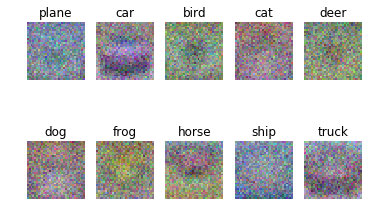

In [57]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])